## For colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/ProjectI'

Mounted at /content/drive
/content/drive/MyDrive/ProjectI


In [ ]:
#unzip file archive.zip
import os 
if not os.path.isdir('/content/drive/MyDrive/ProjectI/Data') : 
  !unzip archive.zip

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Run this first

## Import libraries


In [ ]:
# import 1 số thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import random
import os
from os import system

In [ ]:
# import libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
import gc
from tqdm.notebook import tqdm
import pickle

## Models

In [ ]:
import pickle
with open(os.path.join(os.getcwd(), 'CLASSES.pt'), 'rb') as f:
    CLASSES = torch.load(f)

In [ ]:
class AlexNet_Scratch(nn.Module):
    def __init__(self):       
        super(AlexNet_Scratch, self).__init__()
        # convolutional layer (input shape : 3 x 227 x 227)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4) 
        # convolutional layer (input shape : 96 x 27 x 27)
        self.conv2 = nn.Conv2d(96, 256, 5, padding=2)
        # convolutional layer (input shape : 256 x 27 x 27)
        self.conv3 = nn.Conv2d(256, 384, 3, padding=1)
        # convolutional layer (input shape : 384 x 13 x 13)
        self.conv4 = nn.Conv2d(384, 384, 3, padding=1)
        # convolutional layer (input shape : 384 x 13 x 13)
        self.conv5 = nn.Conv2d(384, 256, 3, padding=1)

        # relu 
        self.relu = nn.ReLU()
        # normalization
        self.bn0 = nn.BatchNorm2d(3)
        self.bn1 = nn.BatchNorm2d(96)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(384)
        self.bn4 = nn.BatchNorm2d(384)
        self.bn5 = nn.BatchNorm2d(256)
        # self.norm = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        # max pooling layer (kernel size = 3 x 3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

        # dropout layer
        self.dropout = nn.Dropout(0.5)
        # fully connected layers
        self.fc1 = nn.Linear(in_features=(256 * 6 * 6), out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=1024)
        self.fc3 = nn.Linear(in_features=1024, out_features=len(CLASSES))
        self.softmax = nn.LogSoftmax(dim=1) # with softmax


    def forward(self, x):
        # reshape image shape to 3 x 227 x 227
        x = transforms.CenterCrop(227)(x)  # out 3 x 277 x 277
        # x = self.bn0(x)
        # conv 1
        x = self.conv1(x)               # out 96 x 55 x 55
        x = self.relu(x)
        x = self.maxpool(x)             # out 96 x 27 x 27
        # x = self.norm(x)
        x = self.bn1(x)
        # conv 2
        x = self.conv2(x)               # out 256 x 27 x 27
        x = self.relu(x)
        x = self.maxpool(x)             # out 256 x 13 x 13
        # x = self.norm(x)
        x = self.bn2(x)
        # conv 3
        x = self.conv3(x)               # out 384 x 13 x 13
        x = self.relu(x)
        x = self.bn3(x)
        # conv 4
        x = self.conv4(x)               # out 384 x 13 x 13
        x = self.relu(x)
        x = self.bn4(x)
        # conv 5
        x = self.conv5(x)               # out 256 x 13 x 13
        x = self.relu(x)
        x = self.maxpool(x)             # out 256 x 6 x 6
        x = self.bn5(x)
        # reduce dimentions for linear layer input
        x = x.view(-1, 256 * 6 * 6)
        # fully connected
        x = self.dropout(x)
        x = self.fc1(x)                 # out 4096
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)                 # out 1024
        x = self.relu(x)
        x = self.fc3(x)                 # out 315
        x = self.softmax(x)  

        return x

In [ ]:
import torchvision.models as models
class ResNet_18_TL(nn.Module):
    def __init__(self, num_classes):
        super(ResNet_18_TL, self).__init__()
        self.network = models.resnet18(pretrained=True)
        number_of_features = self.network.fc.in_features
        self.network.fc = nn.Linear(number_of_features, num_classes)
        
    def forward(self, x):
        return self.network(x)
    
    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad= False
        for param in self.network.fc.parameters():
            param.requires_grad= True
        
    def unfreeze(self):
        for param in self.network.parameters():
            param.requires_grad= True

## Image Retrieval

In [ ]:
__model_name__ = ['AlexNet_Scratch', 'ResNet_18_TL', 'ResNet_18_TL_Full']
class VectorizationNet(nn.Module):
    def __init__(self, backbone):
        super(VectorizationNet, self).__init__()
        self.backbone = backbone
        # copy modules from pretrained model
        if self.backbone == 'AlexNet_Scratch':
            self.model = AlexNet_Scratch()
        elif self.backbone == 'ResNet_18_TL' or self.backbone == 'ResNet_18_TL_Full':
            self.model = ResNet_18_TL(len(CLASSES))
        else:
            raise RuntimeError('unknown backbone')

    def num_flat_features(self, x):
        size = x.size()[1:]     # all dimensions except the batch dimension
        num_feature = 1
        for s in size:
            num_feature *= s

        return num_feature
    
    def forward(self, x):
        if self.backbone == 'AlexNet_Scratch':
            x = transforms.CenterCrop(227)(x)  
            x = self.model.conv1(x)            
            x = self.model.relu(x)
            x = self.model.maxpool(x)       
            x = self.model.bn1(x)
            x = self.model.conv2(x)               
            x = self.model.relu(x)
            x = self.model.maxpool(x)             
            x = self.model.bn2(x)
            x = self.model.conv3(x)               
            x = self.model.relu(x)
            x = self.model.bn3(x)
            x = self.model.conv4(x)               
            x = self.model.relu(x)
            x = self.model.bn4(x)
            x = self.model.conv5(x)               
            x = self.model.relu(x)
            x = self.model.maxpool(x)             
            x = self.model.bn5(x)
            # reduce dimensions to a 1024 vector
            x = x.view(-1, self.num_flat_features(x))
            x = self.model.dropout(x)
            x = self.model.fc1(x)                 # out 4096
            x = self.model.relu(x)
            x = self.model.dropout(x)
            x = self.model.fc2(x)                 # out 1024
            x = self.model.relu(x)
            return x
        elif self.backbone == 'ResNet_18_TL' or self.backbone == 'ResNet_18_TL_Full':
            x = self.model.network.conv1(x)
            x = self.model.network.bn1(x)
            x = self.model.network.relu(x)
            x = self.model.network.maxpool(x)
            x = self.model.network.layer1(x)
            x = self.model.network.layer2(x)
            x = self.model.network.layer3(x)
            x = self.model.network.layer4(x)
            x = self.model.network.avgpool(x)
            x = x.view(-1, self.num_flat_features(x)) # out 512
            return x

In [ ]:
from PIL import Image

def get_img(path: str):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class ImageDataset(Dataset):
    def __init__(self, img_path, label, transform=None):
        super(ImageDataset, self).__init__()
        self.img_path = img_path
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        label    = self.label[idx]
        img_path = self.img_path[idx]
        image    = self.transform(get_img(self.img_path[idx]))
        sample   = {'image' : image, 'img_path' : img_path, 'label' : label}
        return sample

class ImageVectorDataset(Dataset):
    def __init__(self, img_vectors, img_paths, labels):
        super(ImageVectorDataset, self).__init__()
        self.img_vectors = img_vectors
        self.img_paths = img_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_vector  = self.img_vectors[idx]
        img_path    = self.img_paths[idx]
        label       = self.labels[idx]
        sample      = {'img_vector' : img_vector, 'img_path' : img_path, 'label' : label, 'idx' : idx}
        return sample

In [ ]:
batch_size = 256
num_workers = 2
device = 'cpu'

In [ ]:
model_name = 'ResNet_18_TL_Full'
ds_type = 'gallery'
dataset_path = os.path.join(os.getcwd(), 'Image Retrieval', f'{ds_type}_{model_name}.pt')
with open(dataset_path, 'rb') as f:
    gallery = torch.load(f, map_location=torch.device(device))

## Load Model

In [ ]:
def get_model_path(model_name):
    model_path = os.path.join(os.getcwd(), 'Model', f'{model_name}.pt')
    return model_path
device = 'cpu'
# Scatch_model
Scratch_model = AlexNet_Scratch()
Scratch_model.load_state_dict(torch.load(get_model_path('AlexNet_Scratch'), map_location=torch.device(device)))
# ResNet18_Finetune
ResNet18_model = ResNet_18_TL(len(CLASSES))
ResNet18_model.load_state_dict(torch.load(get_model_path('ResNet_18_TL'), map_location=torch.device(device)))
# ResNet18_Full
ResNet18_Full_model = ResNet_18_TL(len(CLASSES))
ResNet18_Full_model.load_state_dict(torch.load(get_model_path('ResNet_18_TL_Full'), map_location=torch.device(device)))
# VectorizationNet
Vectorization_model = VectorizationNet('ResNet_18_TL_Full')
model_path = os.path.join(os.getcwd(), 'Model', f'ResNet_18_TL_Full.pt')
Vectorization_model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

<All keys matched successfully>

## Image Retrieval Prediction
Get prediction by calculate distance between query image and gallery and take top k label

In [ ]:
gallery_loader = DataLoader(gallery, batch_size=batch_size, num_workers=num_workers)

In [ ]:
# ultis functions
import torch.nn.functional as F
def get_distance_matrix(query, gallery_loader, dist_func='euclidean'):
    idx = []
    distance = []

    query_img_vector = query['img_vector']
    query_img_vector = query_img_vector.to(device)

    for batch_idx, batch in enumerate(gallery_loader):
        batch_img_vector = batch['img_vector']
        batch_idx        = batch['idx']
        batch_img_vector = batch_img_vector.to(device)
        # calculate distance
        if dist_func == 'euclidean':
            for iter_img_vector in batch_img_vector:
                distance.append(F.pdist(torch.cat((query_img_vector.view(1, -1), iter_img_vector.view(1, -1)), dim=0)))
        elif dist_func == 'cosine':
            pass
        # store index of distance
        for iter_idx in batch_idx :
            idx.append(iter_idx)
    
    query_img_vector.cpu()
    distance_matrix = []
    for i in range(len(idx)):
        distance_matrix.append({'idx' : idx[i],
                                'distance' : distance[i]})
    return distance_matrix

def predict(query, gallery_loader, dist_func='euclidean' , k=5):
    # compute distance from query vector to all image vector in gallery
    distance_matrix = get_distance_matrix(query, gallery_loader, dist_func)
    distance_matrix = sorted(distance_matrix, key=lambda x: x['distance'].item())
    predictions = {}
    for i in range(k):
        label = gallery_loader.dataset[int(distance_matrix[i]['idx'].item())]['label']
        if label in predictions:
            predictions[label] += 1
        else:
            predictions[label] = 1

    return max(predictions, key=predictions.get)

def show_result_img(query, gallery_loader, dist_func='euclidean'):
    # compute distance from query vector to all image vector in gallery
    distance_matrix = get_distance_matrix(query, gallery_loader, dist_func)
    distance_matrix = sorted(distance_matrix, key=lambda x: x['distance'].item())
    # show query image
    print('Query image')
    plt.imshow(get_img(query['img_path']))
    plt.title(query['label'])
    plt.show()
    # show 9 most similar image
    print('Predicted image')
    fig = plt.figure(figsize=(12,12))
    columns = 3
    rows = 3
    for i in range(1, columns * rows + 1):
        img = get_img(gallery_loader.dataset[int(distance_matrix[i]['idx'].item())]['img_path'])
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.title(gallery_loader.dataset[int(distance_matrix[i]['idx'].item())]['label'])
    plt.show()

## Predict function

In [ ]:
from PIL import Image
import PIL
def show_im(file_path):
    image = Image.open(file_path)
    if type(image) != PIL.JpegImagePlugin.JpegImageFile:
        image = image.covert('RGB')
    plt.imshow(transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224)])(image))
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
import random
import re
def __predict__(img_path, model):

    # load the image and return the predicted
    img = Image.open(img_path)
    # transform the raw image to normalized 3 x 244 x 244 image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).float()
    img_tensor.unsqueeze_(0)  # add dimension.
    img_tensor = Variable(img_tensor) #The input to the network needs to be an autograd Variable

    model.eval()
    output = model(img_tensor) # Returns a Tensor of shape (batch, num class labels)

    # Get the prediction corresponding to the max in output array
    predict_index = output.data.numpy().argmax()

    predicted_breed = CLASSES[predict_index]
    
    return predicted_breed

def get_vector(img_path, model):

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    model.to(device)
    img_set = ImageDataset([img_path], ['unknown'], transform=transform)
    img_loader = DataLoader(img_set, batch_size=1, num_workers=2)

    model.eval()
    
    for batch_idx, batch in enumerate(img_loader):
        batch_imgs, batch_img_paths, batch_labels = batch.values()
        batch_imgs = batch_imgs.to(device)
        with torch.no_grad():
            for img_vector in model(batch_imgs):
                img_vector.cpu()
                output = img_vector
        
    return output

In [ ]:
def run(file_path):
    print('Resized test image : ')
    input = show_im(file_path)
    print('Prediction')
    scratch_pred = __predict__(file_path, Scratch_model)
    resnet1_pred = __predict__(file_path, ResNet18_model)
    resnet2_pred = __predict__(file_path, ResNet18_Full_model)
    print('Scratch Model :', scratch_pred)
    print('ResNet train last layer :', resnet1_pred)
    print('ResNet full train :', resnet2_pred)
    print('\nImage Retrieval')
    query = ImageVectorDataset([get_vector(file_path, Vectorization_model)], [file_path], ['UNKNOWN'])
    show_result_img(query[0], gallery_loader)
    print('Final Result :', predict(query[0], gallery_loader))

# Load image

In [ ]:
# Upload an image
from google.colab import files
file = files.upload()
for k, v in file.items():
    file_path = os.path.join(os.getcwd(), k)

Saving _108857562_mediaitem108857561.jpg to _108857562_mediaitem108857561 (4).jpg


In [ ]:
file_path = ''

Resized test image : 


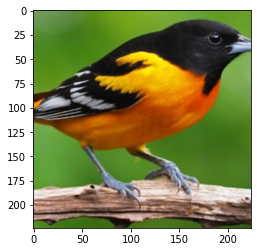

Prediction
Scratch Model : BALTIMORE ORIOLE
ResNet train last layer : BALTIMORE ORIOLE
ResNet full train : BALTIMORE ORIOLE

Image Retrieval
Query image


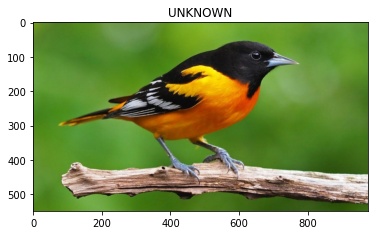

Predicted image


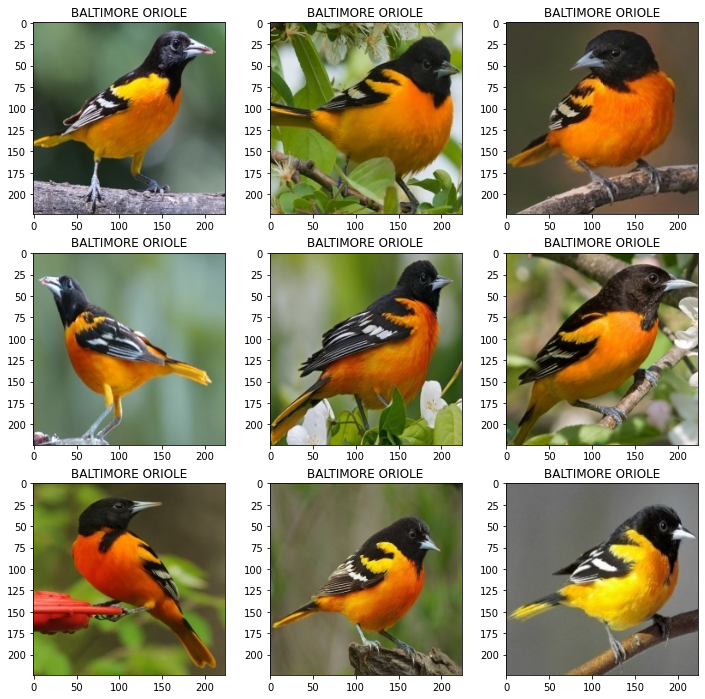

Final Result : BALTIMORE ORIOLE


In [ ]:
run(file_path)